In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
with open('/home/ls3data/datasets/paperswithcode/papers-with-abstracts-extended.json') as f:
    df_paper_abstracts_extended = pd.DataFrame(json.load(f))
with open('/home/ls3data/datasets/paperswithcode/methods.json') as f:
    df_methods = pd.DataFrame(json.load(f))
with open('/home/ls3data/datasets/paperswithcode/datasets.json') as f:
    df_datasets = pd.DataFrame(json.load(f))

## 1. Methods

- Wie viele Collections, Areas gibt es
- Hat jede Method mindestens eine Collection und Area
- Wie ist die Anzahl an Collections/Areas pro Method verteilt
- Sind the Areas eher als Areas der Collection oder Area der Methode zu
verstehen? (Also (1) Method->Collection->Area oder
(2) Area<-Method->Collection)
- usw.

### 1.1 How many collections each method has / belongs to

In [3]:
num_collections =  df_methods.collections.map(lambda x: len(x))
print(f"{sum(num_collections != 0)} out of {len(num_collections)} methods has information about their collection/category \n")

for index, number in num_collections.value_counts().items():
    print(f"{number:,} \t method(s) have {index:,} collection/category" )

1797 out of 1802 methods has information about their collection/category 

1,419 	 method(s) have 1 collection/category
310 	 method(s) have 2 collection/category
57 	 method(s) have 3 collection/category
10 	 method(s) have 4 collection/category
5 	 method(s) have 0 collection/category
1 	 method(s) have 5 collection/category


### 1.2 How to understand the relation between Area, Collection and Method

#### Take the method that has 5 collections as an example:

In [4]:
df_methods[num_collections==5].url

1445    https://paperswithcode.com/method/mirror-bert
Name: url, dtype: object

In [5]:
df_methods[num_collections==5].name

1445    Mirror-BERT
Name: name, dtype: object

In [6]:
df_methods[num_collections==5].collections.values[0]

[{'collection': 'Static Word Embeddings',
  'area_id': 'natural-language-processing',
  'area': 'Natural Language Processing'},
 {'collection': 'Contextualized Word Embeddings',
  'area_id': 'natural-language-processing',
  'area': 'Natural Language Processing'},
 {'collection': 'Word Embeddings',
  'area_id': 'natural-language-processing',
  'area': 'Natural Language Processing'},
 {'collection': 'Sentence Embeddings',
  'area_id': 'natural-language-processing',
  'area': 'Natural Language Processing'},
 {'collection': 'Self-Supervised Learning',
  'area_id': 'general',
  'area': 'General'}]

- Through checking the website of Mirror-BERT and the websites of its respective collections, the conclusion is:\
  Areas contains different Collections/Categories, which contain many different methods, a method can belong to different Collections and Areas at the same time, but Collections can only belong to one certain Area (see Figure **"Num of collections that each Area contains" in section 1.3**)

- The Method "Mirror-BERT" belongs to five different Categories, these five Categories belong to two Areas:\
  **Area:** Natural Language Processing $\frac{has}{}$ (**Collection/Category:** Word Embeddings $\frac{has}{}$) **Collection/Category:** Static Word Embeddings/Contextualized Word Embeddings/Sentence Embeddings $\frac{has}{}$ **Method:** Mirror-BERT \
  **Area:** General $\frac{has}{}$ **Collection/Category:** Self-Supervised Learning $\frac{has}{}$ **Method:** Mirror-BERT

- Example: The Area ["General"](https://paperswithcode.com/methods/area/general) contains the Collection ["Self-Supervised Learning"](https://paperswithcode.com/methods/category/self-supervised-learning) among others, which contains 41 Methods, including "Mirror-BERT" (General -> Self Supervised Learning -> Method)

### 1.3 How many Areas and Collections are there

In [7]:
df_methods_collections = df_methods[num_collections != 0].reset_index(drop=True)

In [8]:
areas = dict()
for list_collec_area in df_methods_collections.collections:
    for dict_element in list_collec_area:        
        area = dict_element.get("area", None)
        collection = dict_element.get("collection", None)
        if area and collection:
            if area not in areas.keys(): 
                areas[area] = []
            if collection not in areas[area]:
                areas[area].append(collection)

In [9]:
collection_list = []
for collection in areas.values():
    collection_list.extend(collection)
    
print(f"there are {len(areas)} Areas and {len(collection_list)} Collections in total, each Collection only belongs to one Area")

there are 7 Areas and 345 Collections in total, each Collection only belongs to one Area


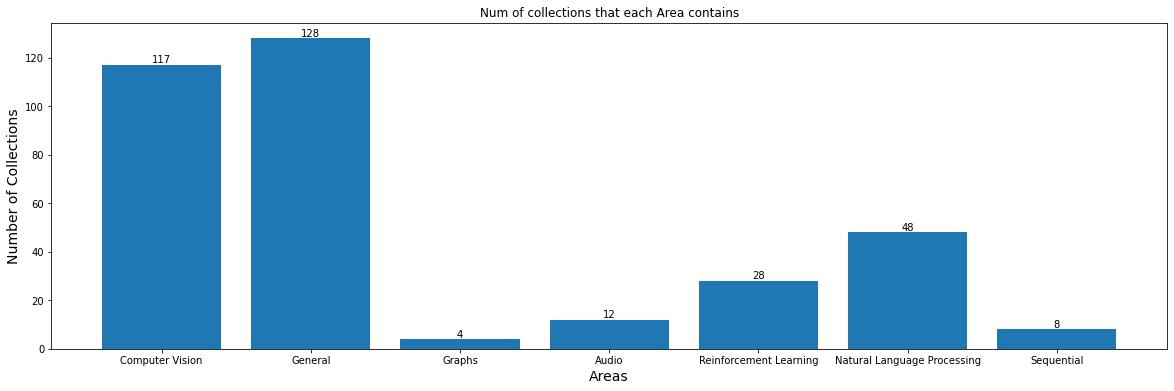

In [10]:
count = []
for area in areas.keys():
    count.append(len(areas[area]))

plt.figure(figsize=(20,6))
plt.xlabel("Areas", fontsize=14)
plt.ylabel("Number of Collections", fontsize=14)
plt.title("Num of collections that each Area contains")
ax = plt.bar(x=areas.keys(), height=count)
labels = plt.bar_label(ax)

### 1.4 Comparison with papers-with-abstracts.json

In papers-with-abstracts.json --> main_collection --> Attribute 'description', 'name', 'parent', 'area' 

Hier bitte überprüfen
- ob man damit allen Collections, die man in methods.json findet,eine description zuordnen kann
- ob die Area-Angabe konsistent ist
- ob sich aus den parent-Angaben eine Hierarchie für die Collections
bestimmen kann

In [11]:
num_methods = df_paper_abstracts_extended.methods.map(lambda x: len(x))
df_paper_abstracts_extended_methods = df_paper_abstracts_extended[num_methods>0].reset_index(drop=True)

methods_df_abstracts = df_paper_abstracts_extended_methods.methods
# methods_df_abstracts

In [12]:
# extract description, parent and area for collections (from df_paper_abstracts_extended)
collec_dpa = dict()
collec_error = []

for list_methods in methods_df_abstracts:
    for method in list_methods:
        
        main_collection = method["main_collection"]
        if main_collection:
            name = main_collection["name"]
            description = main_collection["description"]
            area = main_collection["area"]
            parent = main_collection["parent"]
            
            # if description: # --> with this condition we'wll only get 77 collections that has non-empty descrip!!!!
            if name not in collec_dpa.keys(): # area_test could still be None
                collec_dpa[name] = {"description": description, "parent": parent, "area_new": area}
            # if the info about description or area are not consistent, record the name of this collection
            if  {"description": description, "parent": parent, "area_new": area} != collec_dpa[name]:
                collec_error.append(name)

In [13]:
# info about descriptions and areas for the same collections of different methods (in "df_paper_abstracts_extended") are consistent 
len(collec_error)

0

In [14]:
# there are 282 collctions which has description
# (actully only 77 collections have non-empty descriptions)
len(collec_dpa)

282

#### 1.4.1 Can every "Collection" in df_methods get a description from df_paper_abstract_extended + are info about Area consistent?

In [15]:
collections_without_descrip = []
collections_inconsistent_area = []

for list_collections in df_methods_collections.collections:
    for collection_dict in list_collections:
        collection = collection_dict["collection"]
        area = collection_dict["area"]
        

        if collection not in collec_dpa.keys():
            # no info about this collection can be found in "df_paper_abstracts_extended":
            collection_dict.update({"description": None, "parent": None})
            # record the name of this collection
            if collection not in collections_without_descrip:
                collections_without_descrip.append(collection)
        else:
            area_new = collec_dpa[collection]["area_new"]
            if area_new and area != area_new:
                collections_inconsistent_area.append(collection)
                
            # some collection will be updated with empty description (but "area_test" may not be empty)
            collection_dict.update({"description": collec_dpa[collection]["description"], 
                                    "parent": collec_dpa[collection]["parent"]})        

In [16]:
# collections that "df_paper_abstracts_extended" does not have but "df_methods" does
len(collections_without_descrip)

63

In [17]:
# This means all 282 collections from "df_paper_abstracts_extended" also exist in "df_methods"
# and there are also 63 collections in "df_methods" that "df_paper_abstracts_extended" doesn't contain
len(collec_dpa) + len(collections_without_descrip) == len(collection_list)

True

In [18]:
# no inconsistent areas
len(collections_inconsistent_area)

0

**Conclusions**:
   - There are 282 different collections in df_paper_abstracts_extended, all these collections also exist in "df_methods" (345 collections), but only 77 of these 282 have non-empty descriptions.
   - Those "area_new" (for 282 collections) who are not None, they are all consistent with the original "area"

#### 1.4.2 How to understand the hierarchy of "Parent"

In [19]:
df_methods_collections_parents = pd.DataFrame(columns=df_methods_collections.columns)
for _, row in df_methods_collections.iterrows():
    for collections_dict in row.collections:
        if collections_dict["parent"]:
            row_df = pd.DataFrame(row).T
            df_methods_collections_parents = pd.concat([df_methods_collections_parents, row_df])
            continue

In [20]:
example = df_methods_collections_parents.sample(1)
print(f"Method Name: \t {example.name.iloc[0]}\n")
print(f"{example.url.iloc[0]}\n")
print(example.collections.iloc[0])

Method Name: 	 NAS-FPN

https://paperswithcode.com/method/nas-fpn

[{'collection': 'Feature Pyramid Blocks', 'area_id': 'computer-vision', 'area': 'Computer Vision', 'description': '**Feature Pyramid Blocks** are a basic component in recognition systems for detecting objects at different scales.', 'parent': 'Feature Extractors'}, {'collection': 'Feature Extractors', 'area_id': 'computer-vision', 'area': 'Computer Vision', 'description': '**Feature Extractors** for object detection are modules used to construct features that can be used for detecting objects. They address issues such as the need to detect multiple-sized objects in an image (and the need to have representations that are suitable for the different scales).', 'parent': None}]


**Conclusion**
- "Parent" is a direct upper class/hierarchy of "Collection", for those whose "Parent" is None, most likely means that the "Area" is its direct upper class
- For the cases where Parent does exist:
    1. Example1 (The most common and simple case): For Method [MLFPN](https://paperswithcode.com/method/mlfpn), one of its Collection is ["Feature Pyramid Blocks"](https://paperswithcode.com/methods/category/feature-pyramid-blocks), which has Parent ["Feature Extractors"](https://paperswithcode.com/methods/category/feature-extractors) and belongs to Area ["Computer Vision"](https://paperswithcode.com/methods/area/computer-vision).
       So the hierarchy would be: **Area** "Computer Vision" $\frac{has}{subarea}$ **Parent (of Collection)** "Feature Extractors" $\frac{has}{child}$ **Collection** "Feature Pyramid Blocks"
       
    2. Example2: For **Method:** [MacBERT](https://paperswithcode.com/method/macbert): \
        One of its **Collection** is ['Autoencoding Transformers'](https://paperswithcode.com/methods/category/autoencoding-transformers) $\frac{has}{parent}$ **Parent** ['Transformers'](https://paperswithcode.com/methods/category/transformers) $\frac{belongs}{to}$ **Area** ['Natural Language Processing'](https://paperswithcode.com/methods/area/natural-language-processing) \
        Another **Collection** is ['Transformers'](https://paperswithcode.com/methods/category/transformers) which $\frac{has}{parent}$ ['Language Models'](https://paperswithcode.com/methods/category/language-models), which $\frac{belongs}{to}$ **Area** ['Natural Language Processing'](https://paperswithcode.com/methods/area/natural-language-processing)
        
    3. Example3: Notice that not all Parents that exist in Papers With Code exist in our dataset. E.g. For **Method** [XLNet](https://paperswithcode.com/method/xlnet), which belongs to the **Collection**  ['Autoregressive Transformers'](https://paperswithcode.com/methods/category/autoregressive-transformers), which has **Parent** ['Transformer'](https://paperswithcode.com/methods/category/transformers) as shown on the website, but in our dataset, its Parent is None (Its Area is indeed Natural Language Processing)

    4. Lastly, a very general relation between the three could be summarized as:\
        **Area --> Parents (if there are any) --> Collections** \
       (Possible reasons when Parent is None: either we failed at getting the infomation about Parent, or the direct parent of "Collection" is just "Area", in the latter case Parent will be shown as None)

<details>
    <summary> Show details about <strong>MacBERT</strong> </summary>

Method Name: 	 MacBERT

https://paperswithcode.com/method/macbert

[{'collection': 'Autoencoding Transformers', 
    'area_id': 'natural-language-processing', 
    'area': 'Natural Language Processing', 
    'description': '', 
    'parent': 'Transformers'}, 
    
 {'collection': 'Transformers', 
    'area_id': 'natural-language-processing', 
    'area': 'Natural Language Processing', 
    'description': '**Transformers** are a type of neural network architecture that have several properties that make them effective for modeling data with long-range dependencies. They generally feature a combination of multi-headed attention mechanisms, residual connections, layer normalization, feedforward connections, and positional embedidngs.', 
    'parent': 'Language Models'}]

</details>

## 2. Dataset

- Analog für datasets.json wäre eine Auswertung folgender Attribute hilfreich: introduced_date, warning, modalities, languages, variants.


In [21]:
df_datasets_seperated = df_datasets[["name","introduced_date", "warning", "modalities", "languages", "variants"]]
len(df_datasets_seperated)

5124

In [22]:
df_datasets_seperated.notna().sum()

name               5124
introduced_date    3082
warning               0
modalities         5124
languages          5124
variants           5124
dtype: int64

- no info in the "warning" column, will be dropped later
- a lot None in "introduced_date"
- the last three features stores information in list, they need further analyses

In [23]:
df_datasets_seperated = df_datasets_seperated.drop(columns = ["warning"])

### 2.1 How are the introduced dates distributed

In [24]:
# Dropna and take "year" as analysing unit
date_year = df_datasets_seperated.introduced_date.dropna().apply(lambda x: x.split("-")[0])

In [25]:
date_year.min()

'1982'

In [26]:
date_year.max()

'2027'

In [27]:
# take 5 years as one obervation interval
bins = [str(x) for x in range(1977, 2032, 5)]
date_year_cutted = pd.cut(x=date_year, bins=bins, labels=[i for i in bins][:-1])

In [28]:
# e.g. 2017 means the Interval (2017,2022], including all datasets in the year 2022
date_year_cutted.value_counts()

2017    2217
2012     637
2007     140
2002      52
1997      22
1992       9
1987       3
1977       1
2022       1
1982       0
Name: introduced_date, dtype: int64

In [29]:
# ax = sns.countplot(x=date_year_cutted)

In [30]:
# one error - the original ditribution date of this dataset should be 1980
df_datasets[df_datasets.introduced_date > "2022-01-01"]

,url,name,full_name,homepage,description,paper,introduced_date,warning,modalities,tasks,languages,variants,num_papers,data_loaders
4462,https://paperswithcode.com/dataset/mit-bih-arr...,MIT-BIH Arrhythmia Database,,https://physionet.org/content/mitdb/1.0.0/,The MIT-BIH Arrhythmia Database contains 48 ha...,None,2027-05-28,None,[Medical],[],[English],[MIT-BIH Arrhythmia Database],2,[]


- The most datasets we have are published between 2017 and 2022, only a tiny fraction comes from before 2000

----

### 2.2 Modalities

In [31]:
num_modalities = df_datasets_seperated.modalities.map(lambda x: len(x))
df_name_modalities = df_datasets_seperated[num_modalities>0][["name", "modalities"]].reset_index(drop=True)
print(f"{len(df_name_modalities)} out of {len(df_datasets_seperated)} datasets has information about their modalities")

3793 out of 5124 datasets has information about their modalities


In [32]:
# most datasets possess one modality
num_modalities.value_counts()

1    2865
0    1331
2     740
3     150
4      26
5       8
6       2
9       1
8       1
Name: modalities, dtype: int64

In [33]:
modalities = dict()
for _, row in df_name_modalities.iterrows():
    for element in row.modalities:
        if element not in modalities.keys():
            modalities[element] = []
        modalities[element].append(row[0])

In [34]:
modalities

{'Images': ['MNIST',
  'CelebA',
  'JFT-300M',
  'ImageNet',
  'LFW',
  'Food-101',
  'Fashion-MNIST',
  'CINIC-10',
  'Flickr30k',
  'COCO',
  'MHP',
  'FDDB',
  'GOT-10k',
  'DukeMTMC-reID',
  'KITTI',
  'TID2013',
  'Visual Genome',
  'COCO-Stuff',
  'iLIDS-VID',
  'Market-1501',
  'VIPeR',
  'CUHK01',
  'CUHK03',
  'VehicleID',
  'BP4D',
  'DISFA',
  'CUB-200-2011',
  'SUN397',
  'ICDAR 2013',
  'Visual Madlibs',
  'DAQUAR',
  'Visual7W',
  'FM-IQA',
  'RecipeQA',
  'VCR',
  'AFW',
  'MMI',
  'JAFFE',
  'Oulu-CASIA',
  'SFEW',
  'MSRA-TD500',
  'Total-Text',
  'DOTA',
  'HRSC2016',
  'ShanghaiTech',
  'UCSD',
  'OTB-2015',
  'OTB-2013',
  'TrackingNet',
  'VOT2018',
  'GTA5',
  'Middlebury',
  'V-COCO',
  'HICO-DET',
  'UTD-MHAD',
  'MPII',
  'MSRC-12',
  'Volleyball',
  'MOT16',
  'NUS-WIDE',
  'PASCAL VOC 2007',
  'CelebA-HQ',
  'GTEA',
  'DIV2K',
  'CASIA-B',
  'AFLW',
  'BIWI',
  'YCB-Video',
  'ApolloCar3D',
  'DAVIS 2016',
  'FBMS-59',
  'CamVid',
  'DAVIS 2017',
  'SVHN',
  

In [35]:
num_datasets = dict()
num_datasets_sorted = dict()

for key in modalities.keys():
    num_datasets[key] = len(modalities[key])

for key_sorted in sorted(num_datasets, key=num_datasets.get, reverse=True):
    num_datasets_sorted[key_sorted] = num_datasets[key_sorted]
    
print(f"there are {len(num_datasets_sorted)} different modalities in total")

there are 39 different modalities in total


In [36]:
# Images, Text and Videos are the most frequent modalities
num_datasets_sorted

{'Images': 1608,
 'Texts': 1440,
 'Videos': 510,
 'Audio': 250,
 'Medical': 182,
 '3D': 150,
 'Graphs': 118,
 'Speech': 108,
 'RGB-D': 85,
 'Environment': 79,
 'Time series': 58,
 'Point cloud': 44,
 'Biomedical': 39,
 'Tabular': 36,
 'LiDAR': 26,
 'Tracking': 21,
 'Stereo': 19,
 'Hyperspectral images': 19,
 'Biology': 18,
 'MRI': 16,
 'Interactive': 14,
 '3d meshes': 14,
 'Dialog': 13,
 'Music': 13,
 'Actions': 13,
 'Physics': 12,
 'RGB Video': 10,
 'Tables': 9,
 'EEG': 7,
 'Midi': 7,
 '6D': 6,
 'Parallel': 4,
 'Replay data': 4,
 'Financial': 4,
 'Cad': 3,
 'Ranking': 3,
 'fMRI': 3,
 'Lyrics': 2,
 'PSG': 1}

--- 

### 2.3 Languages

In [37]:
num_languages = df_datasets_seperated.languages.map(lambda x: len(x))
df_name_languages = df_datasets_seperated[num_languages>0][["name", "languages"]].reset_index(drop=True)
print(f"{len(df_name_languages)} out of {len(df_datasets_seperated)} datasets has information about their languages")

1483 out of 5124 datasets has information about their languages


In [38]:
languages = dict()
for _, row in df_name_languages.iterrows():
    for element in row.languages:
        if element not in languages.keys():
            languages[element] = []
        languages[element].append(row[0])

In [39]:
num_datasets = dict()
for key in languages.keys():
    num_datasets[key] = len(languages[key])

print(f"there are {len(num_datasets)} different languages in total")

there are 341 different languages in total


In [40]:
# first 10 -- there might be overlapping, e.g. some datasets may have multiple languages
keys = sorted(num_datasets, key=num_datasets.get, reverse=True)[:10]
# count = 0
for key in keys:
    # count += num_datasets[key]
    print(f"{key} :\t{num_datasets[key]}")
# print(f"In total: {count}")

English :	1132
Chinese :	150
German :	107
French :	78
Spanish :	69
Russian :	68
Japanese :	53
Arabic :	51
Italian :	48
Portuguese :	44


In [41]:
# proportion of datasets that use english (out of datasets that has information about their languages)
num_datasets["English"]/len(df_name_languages)

0.7633175994605529

- The infomation about dataset's language is poor, generally speaking, nearly 80% of datasets use english (but might not only use english)
- What info can we have by looking at datasets' languages?

---

### 2.4 Modalities and Languages

In [42]:
df_name_mod_lang = df_datasets_seperated[(num_modalities>0)&(num_languages>0)][["name", "modalities", "languages"]].reset_index(drop=True)
print(f"there are only {len(df_name_mod_lang)} out of {len(df_datasets)} datasets that have info about both their modalities and languages") 

there are only 1318 out of 5124 datasets that have info about both their modalities and languages


In [43]:
# modalities that have information about their languages
mod = []
for list_m in df_name_mod_lang.modalities:
    for m in list_m:
        if m not in mod:
            mod.append(m)
print(f"there are {len(mod)} out of {len(modalities.keys())} modalities has info about their languages")

there are 34 out of 39 modalities has info about their languages


In [44]:
mod_lang = dict() 
for _, row in df_name_mod_lang.iterrows():
    mod_list = row.modalities
    lang_list = row.languages
    
    for mod in mod_list:
        if mod not in mod_lang.keys():
            mod_lang[mod] = []
        for lang in lang_list:
            mod_lang[mod].append(lang)

In [45]:
# pd.DataFrame(mod_lang['Texts']).value_counts().iloc[:4].sum() / pd.DataFrame(mod_lang['Texts']).value_counts().sum()

In [46]:
pd.DataFrame(mod_lang['Texts']).value_counts() # .sum()

English                         756
Chinese                         107
German                           79
French                           60
Spanish                          54
                               ... 
Northern Kurdish                  1
Northern Frisian                  1
Newari                            1
Nepali (individual language)      1
Luo (Cameroon)                    1
Length: 228, dtype: int64

In [47]:
pd.DataFrame(mod_lang['Images']).value_counts() # .sum()

English                      236
Chinese                       22
German                        11
French                         8
Arabic                         6
Japanese                       5
Spanish                        5
Russian                        4
Bengali                        3
Hindi                          3
Turkish                        3
Italian                        3
Portuguese                     3
Multilingual                   2
Telugu                         2
Tamil                          2
Vietnamese                     2
Mandarin Chinese               1
Malayalam                      1
Bangladeshi Sign Language      1
Korean                         1
Standard Arabic                1
Swahili                        1
Kazakh                         1
Kannada                        1
Thai                           1
Indonesian                     1
Latin                          1
dtype: int64

In [48]:
pd.DataFrame(mod_lang['Videos']).value_counts() # .sum()

English                       74
Chinese                        6
Spanish                        3
Portuguese                     3
German                         3
Hindi                          3
Japanese                       2
Korean                         2
Multilingual                   2
Turkish Sign Language          2
French                         2
Arabic                         1
Italian                        1
Greek Sign Language            1
Russian                        1
Bengali                        1
Swiss German                   1
Swiss-German Sign Language     1
Telugu                         1
American Sign Language         1
dtype: int64

In [49]:
pd.DataFrame(mod_lang['Audio']).value_counts() # .sum()

English        51
Chinese        10
French          9
German          8
Spanish         7
               ..
Hebrew          1
Hakha Chin      1
Gujarati        1
Greek           1
Yue Chinese     1
Length: 127, dtype: int64

- For the above four most common modalities, English, Chinese, German are the most frequently used languages
- "Texts" tend to have info about their languages comparing to other modalities

---

### 2.5 Variants

In [50]:
num_variants = df_datasets_seperated.variants.map(lambda x: len(x))

In [51]:
# 4588 datasets have one variant, 16 datasets have no variants
num_variants.value_counts()

1     4588
2      253
3      110
4       47
5       31
7       24
0       16
6       14
8        9
9        6
16       4
12       3
15       3
19       2
13       2
11       2
46       1
29       1
38       1
26       1
17       1
10       1
57       1
14       1
37       1
59       1
Name: variants, dtype: int64

In [52]:
num_variants = pd.DataFrame(num_variants.sort_values(ascending=False)).reset_index(drop=True)

<AxesSubplot:xlabel='index', ylabel='variants'>

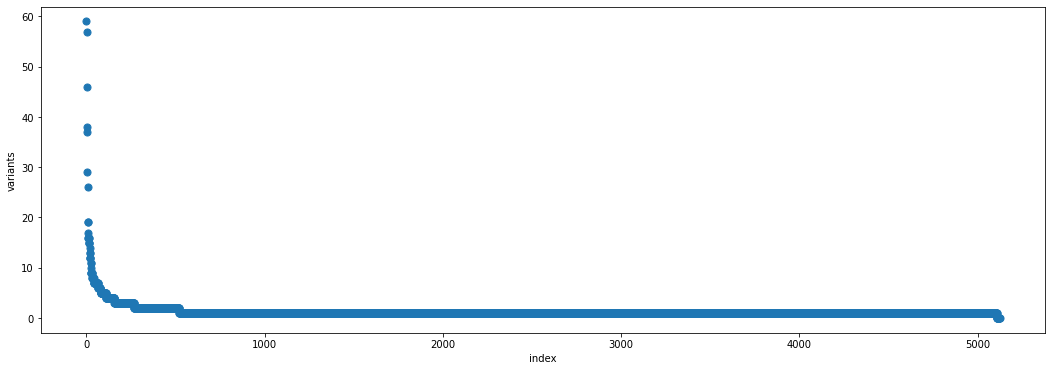

In [53]:
num_variants.reset_index().plot(kind="scatter", x="index", y="variants", figsize=(18,6), s=50)

In [54]:
# 99% datasets have less than 10 variants
sum(num_variants.squeeze()<5) / len(num_variants)

0.9785323965651834

#### Analyse the the relations between "number of variant" and the "introduced date" of a dataset:

In [55]:
# 26 datasets have more than 10 variants
dates_variants = df_datasets_seperated[num_variants.squeeze()>=5].introduced_date.dropna()
year_variants = dates_variants.apply(lambda x: x.split("-")[0])

In [56]:
print(year_variants.min())
print(year_variants.max())

1990
2020


In [57]:
bins = [str(x) for x in range(1990, 2025, 5)]
year_variants_cutted = pd.cut(x=date_year, bins=bins, labels=[i for i in bins][:-1])

In [58]:
# len(dates_variants) / len(df_datasets_seperated[num_variants.squeeze()>=5])

In [59]:
year_variants_cutted.value_counts()

2015    1578
2010     330
2005      85
2000      41
1995      13
1990       6
Name: introduced_date, dtype: int64

<AxesSubplot:xlabel='index', ylabel='introduced_date'>

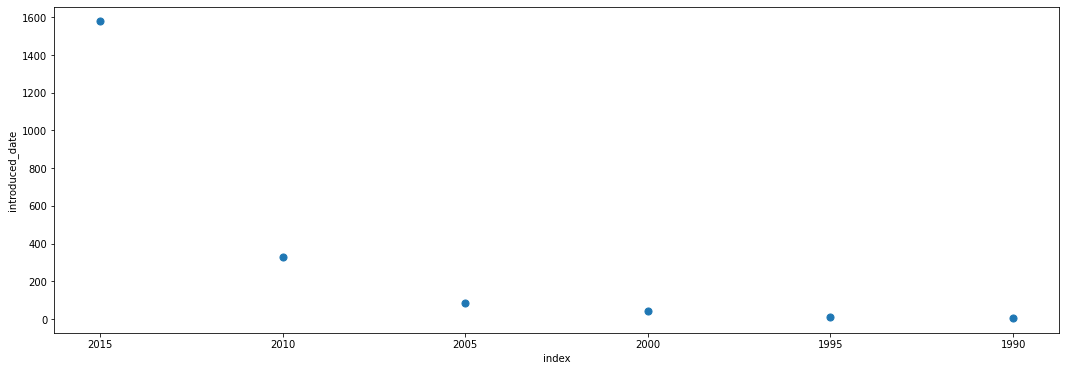

In [60]:
pd.DataFrame(year_variants_cutted.value_counts()).reset_index().plot(
    kind="scatter", x="index",y="introduced_date", s=50, figsize=(18,6)
)

- Most datasets has only 1 - 5 variants (about 98% of all datasets)
- For those who has more than 5 (including 5) variants, the trend is: The more "fresh" the dataset is, the more variants it tends to have (and the trend looks a bit exponential) 